Nov 3, 2022

 MCMC a 1-power law model for the relation between M_z vs #GCs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.table import Table

In [3]:
from tqdm import tqdm

In [4]:
import astropy.io.fits as fits

In [5]:
import corner

In [6]:
import emcee

In [7]:
from scipy.optimize import minimize

In [8]:
from IPython.display import display, Math

do MCMC

In [9]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [10]:
y = data['NGCs']
x = data['Mag z']
yerr = data['err GC']

In [11]:
a = np.argwhere(~np.isnan(x)) #find idx of non nan values in Mag z

In [12]:
x    = x[a]
y    = y[a]
yerr = yerr[a]

In [13]:
x    = x.reshape((len(a)))
y    = y.reshape((len(a)))
yerr = yerr.reshape((len(a)))

Try with 1-power law model

$y(x) = a.e^{-\alpha x}$

In [105]:
def model(theta, x):
    a, alpha, log_f = theta
    model = a*np.exp(-alpha*x) 
    return model

In [106]:
def log_likelihood(theta, x, y, yerr):
    a, alpha, log_f = theta
    sigma2 = yerr**2 + model(theta,x)**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(theta,x)) ** 2 / sigma2 + np.log(sigma2))


In [135]:
#initial values (guess)
a_ini     = 1e-5
alpha_ini = 0.5
f_ini     = 0.2 
ini  = np.array([a_ini, alpha_ini, np.log(f_ini)]) 
ndim = len(ini)

In [136]:
np.random.seed(42)
nll     = lambda *args: -log_likelihood(*args)
initial = ini + 1e-3 * np.random.randn(ndim)
soln    = minimize(nll, initial, args=(x, y, yerr))
a_ml, alpha_ml, log_f_ml = soln.x

theta_ml = [a_ml, alpha_ml,log_f_ml]

print("Maximum likelihood estimates:")
print("a     = {0:.8f}".format(a_ml))
print("alpha = {0:.8f}".format(alpha_ml))
print("f     = {0:.8f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a     = 0.00000124
alpha = 0.92361659
f     = 0.85411967


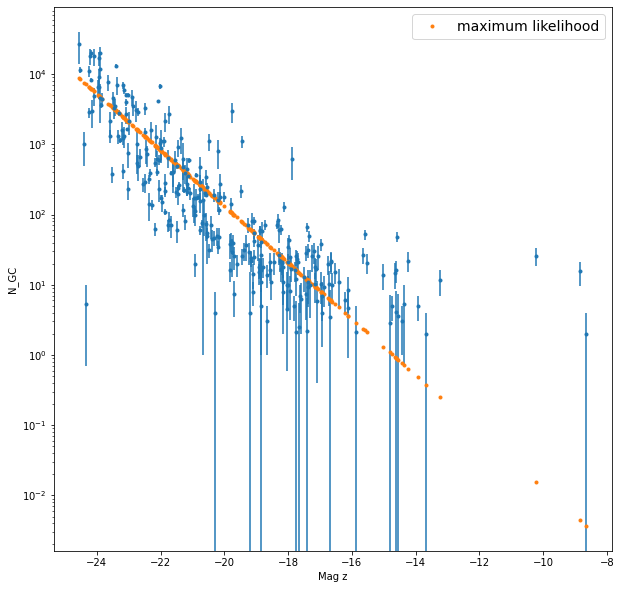

In [137]:
plt.figure(figsize=(10,10))
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.plot(x, model(theta_ml, x), '.', label = 'maximum likelihood')
plt.legend(fontsize=14)
plt.xlabel("Mag z")
plt.yscale('log')
plt.ylabel("N_GC");

In [138]:
def log_prior(theta):
    a, alpha, log_f = theta
    if -3e-5 < a < 1e-5 and 0 < alpha < 2 and -10.0 < log_f < 10:
        return 0.0
    return -np.inf

In [139]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [140]:
nwalkers = 240 # no. of paramters x 40
pos = soln.x + 1e-5 * np.random.randn(nwalkers, ndim)
niter = 5000  # nwalkers x 1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, niter, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/cluster/home/lemn/.conda/envs/project2/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:59<00:00, 84.64it/s]


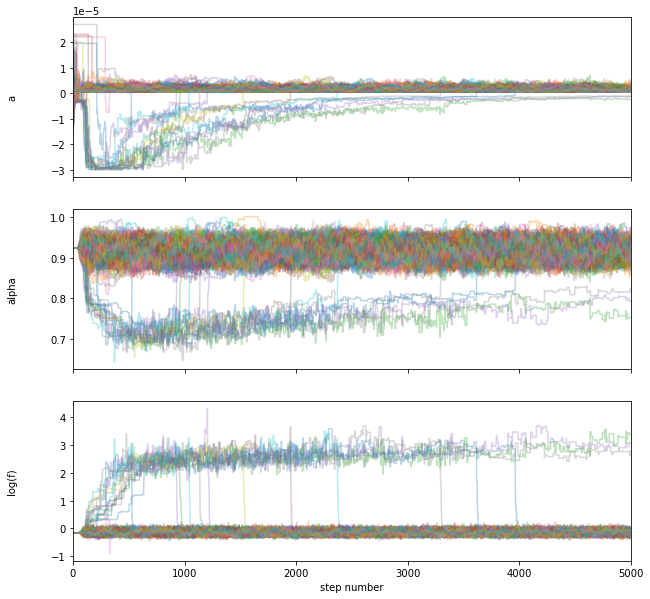

In [141]:
fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["a", 'alpha', "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [142]:
flat_samples = sampler.get_chain(discard=150, thin=50, flat=True) #thin the samples ~ 0.5 of autocorr time
print(flat_samples.shape)

(23280, 3)


In [143]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [148.53850312 153.02500511  75.76490787]

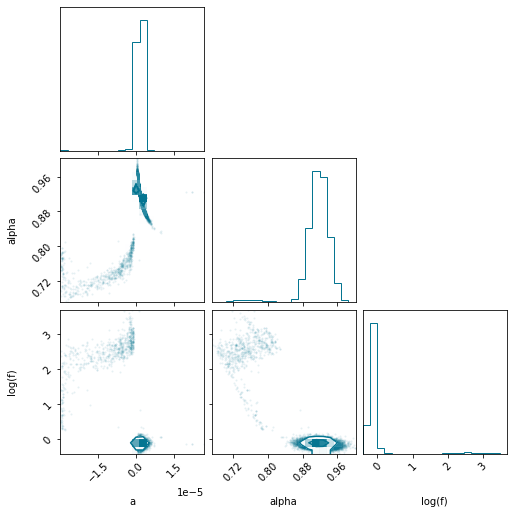

In [144]:
fig = corner.corner(flat_samples, labels=labels, color='#047591')
#fig.savefig('corner_constrain.pdf')

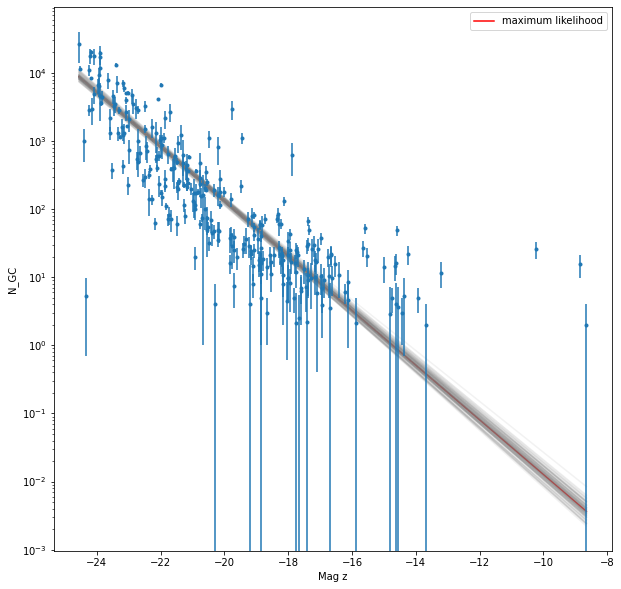

In [145]:
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize=(10,10))
plt.yscale('log')
models = []
x2 = np.sort(x)
plt.plot(x2, model(theta_ml, x2), 'r-', label = 'maximum likelihood')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x2, model(sample,x2), color='grey', alpha = 0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC")
plt.legend()
#plt.savefig('parameters_100.pdf')

In [146]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.8f}}}^{{+{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>